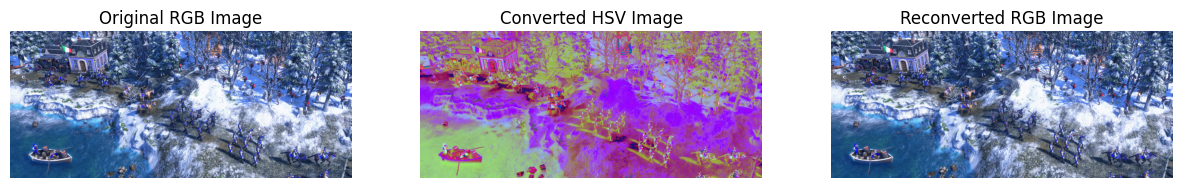

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def rgb_to_hsv_pixel(r, g, b):
    r, g, b = r / 255.0, g / 255.0, b / 255.0
    max_val = max(r, g, b)
    min_val = min(r, g, b)
    delta = max_val - min_val

    if delta == 0:
        h = 0
    elif max_val == r:
        h = (60 * ((g - b) / delta) + 360) % 360
    elif max_val == g:
        h = (60 * ((b - r) / delta) + 120) % 360
    else:
        h = (60 * ((r - g) / delta) + 240) % 360

    s = 0 if max_val == 0 else delta / max_val
    v = max_val

    return h, s, v

def hsv_to_rgb_pixel(h, s, v):
    h = h % 360
    d = h / 60
    hi = int(d) % 6
    f = d - hi

    l = v * (1 - s)
    m = v * (1 - f * s)
    n = v * (1 - (1 - f) * s)

    if hi == 0:
        r, g, b = v, n, l
    elif hi == 1:
        r, g, b = m, v, l
    elif hi == 2:
        r, g, b = l, v, n
    elif hi == 3:
        r, g, b = l, m, v
    elif hi == 4:
        r, g, b = n, l, v
    else:
        r, g, b = v, l, m

    return int(r * 255), int(g * 255), int(b * 255)

def convert_rgb_to_hsv_image(image):
    width, height = image.size
    hsv_image = np.zeros((height, width, 3), dtype=np.float32)

    for y in range(height):
        for x in range(width):
            r, g, b = image.getpixel((x, y))
            h, s, v = rgb_to_hsv_pixel(r, g, b)
            hsv_image[y, x] = (h / 360, s, v)

    return hsv_image

def convert_hsv_to_rgb_image(hsv_image):
    height, width, _ = hsv_image.shape
    rgb_image = Image.new("RGB", (width, height))
    pixels = rgb_image.load()

    for y in range(height):
        for x in range(width):
            h, s, v = hsv_image[y, x]
            h = h * 360
            r, g, b = hsv_to_rgb_pixel(h, s, v)
            pixels[x, y] = (r, g, b)

    return rgb_image

image_path = 'mediterranean-splash3-4k-scaled.png'
original_image = Image.open(image_path).convert("RGB")

hsv_image = convert_rgb_to_hsv_image(original_image)
reconverted_rgb_image = convert_hsv_to_rgb_image(hsv_image)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original RGB Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(hsv_image)
plt.title("Converted HSV Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(reconverted_rgb_image)
plt.title("Reconverted RGB Image")
plt.axis("off")

plt.show()

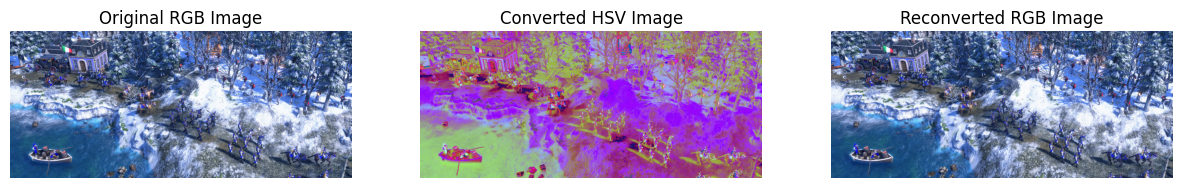

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from PIL import Image

def rgb_to_hsv_pixel(r, g, b):
    r, g, b = r / 255.0, g / 255.0, b / 255.0
    max_val = max(r, g, b)
    min_val = min(r, g, b)
    delta = max_val - min_val

    if delta == 0:
        h = 0
    elif max_val == r:
        h = (60 * ((g - b) / delta) + 360) % 360
    elif max_val == g:
        h = (60 * ((b - r) / delta) + 120) % 360
    else:
        h = (60 * ((r - g) / delta) + 240) % 360

    s = 0 if max_val == 0 else delta / max_val
    v = max_val

    return h, s, v

def hsv_to_rgb_pixel(h, s, v):
    h = h % 360
    d = h / 60
    hi = int(d) % 6
    f = d - hi

    l = v * (1 - s)
    m = v * (1 - f * s)
    n = v * (1 - (1 - f) * s)

    if hi == 0:
        r, g, b = v, n, l
    elif hi == 1:
        r, g, b = m, v, l
    elif hi == 2:
        r, g, b = l, v, n
    elif hi == 3:
        r, g, b = l, m, v
    elif hi == 4:
        r, g, b = n, l, v
    else:
        r, g, b = v, l, m

    return int(r * 255), int(g * 255), int(b * 255)

def convert_rgb_to_hsv_image_cuda(image):
    rgb_image = cp.asarray(image, dtype=cp.float32) / 255.0
    r, g, b = rgb_image[..., 0], rgb_image[..., 1], rgb_image[..., 2]

    max_val = cp.max(rgb_image, axis=2)
    min_val = cp.min(rgb_image, axis=2)
    delta = max_val - min_val

    h = cp.zeros_like(max_val)
    h = cp.where((delta == 0), 0, h)
    h = cp.where((delta != 0) & (max_val == r), (60 * ((g - b) / delta) + 360) % 360, h)
    h = cp.where((delta != 0) & (max_val == g), (60 * ((b - r) / delta) + 120) % 360, h)
    h = cp.where((delta != 0) & (max_val == b), (60 * ((r - g) / delta) + 240) % 360, h)

    s = cp.where(max_val == 0, 0, delta / max_val)

    v = max_val

    hsv_image = cp.stack((h / 360, s, v), axis=2)
    return hsv_image

def convert_hsv_to_rgb_image_cuda(hsv_image):
    hsv_image = cp.asarray(hsv_image)
    h, s, v = hsv_image[..., 0] * 360, hsv_image[..., 1], hsv_image[..., 2]

    d = h / 60
    hi = cp.floor(d).astype(int) % 6
    f = d - hi

    l = v * (1 - s)
    m = v * (1 - f * s)
    n = v * (1 - (1 - f) * s)

    r = cp.where(hi == 0, v, cp.where(hi == 1, m, cp.where(hi == 2, l, cp.where(hi == 3, l, cp.where(hi == 4, n, v)))))
    g = cp.where(hi == 0, n, cp.where(hi == 1, v, cp.where(hi == 2, v, cp.where(hi == 3, m, cp.where(hi == 4, l, l)))))
    b = cp.where(hi == 0, l, cp.where(hi == 1, l, cp.where(hi == 2, n, cp.where(hi == 3, v, cp.where(hi == 4, v, m)))))

    rgb_image = cp.stack((r, g, b), axis=2) * 255
    return rgb_image.astype(cp.uint8)

image_path = 'mediterranean-splash3-4k-scaled.png'
original_image = np.array(Image.open(image_path).convert("RGB"))

hsv_image_cuda = convert_rgb_to_hsv_image_cuda(original_image)
reconverted_rgb_image_cuda = convert_hsv_to_rgb_image_cuda(hsv_image_cuda)

hsv_image_cpu = cp.asnumpy(hsv_image_cuda)
reconverted_rgb_image_cpu = Image.fromarray(cp.asnumpy(reconverted_rgb_image_cuda))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original RGB Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(hsv_image_cpu)
plt.title("Converted HSV Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(reconverted_rgb_image_cpu)
plt.title("Reconverted RGB Image")
plt.axis("off")

plt.show()